# TensorFlow 2
## Convolutional Neural Network

Here, I will implement a simple Convolutional Neural Network in TensorFlow for the same problem in "Tensorflow 1". The accuracy is expected to be more here, as convolutional neural network learn images more than the normal neural networks.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

## Imports

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import warnings
warnings.filterwarnings('ignore')

Tensorflow version at the time of writing this notebook

In [2]:
print(tf.__version__)

1.5.0


## Configuration of ConvNet

In [3]:
# Convolutional layer 1 
filter_size1 = 5     # Convolution filters are 5 x 5 pixels.
num_filters1 = 16    # There are 16 of these filters.

# Convolutional layer 2
filter_size2 = 5     # Convolution filters are 5 x 5 pixels.
num_filters2 = 36    # There are 16 of these filters.

# COnvolutional layer 3
fc_size = 128        # Number of neurons in fully-connected layer.

## Loading Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set consists of 70,000 images and associated labels.

In [5]:
print('Train data volume: ', len(data.train.labels))
print('Test data volume: ', len(data.test.labels))
print('Validation data volume: ', len(data.validation.labels))

Train data volume:  55000
Test data volume:  10000
Validation data volume:  5000


In [6]:
# Defining attribute to contain true class labels in integer format as opposed to on-hot encodings
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

In [7]:
img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

### Helper Functions for plotting images

In [70]:
def plot_images(images, cls_true, cls_pred=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            x_label = 'True: {0}'.format(np.argmax(cls_true[i]))
        else:
            x_label = 'True: {0}, Pred {1}'.format(np.argmax(cls_true[i]), np.argmax(cls_pred[i]))
        ax.set_xlabel(x_label)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Plotting some images to see the results of above function

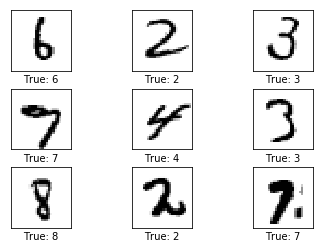

In [71]:
images = data.train.images[0:9]
cls_true = data.train.labels[0:9]
plot_images(images, cls_true)

## Building the Tensorflow Graph

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper Function to create convolutional layers

In [11]:
def new_convolutional_layer(conv_prev          # Activation of precious layer
                           ,num_input_channels # Number of channels in the previous layer
                           ,filter_size        # Width and height of the filter in the current conv layer
                           ,num_filters        # Number of filters in the current layer
                           ,use_pooling=True): # Use 2x2 Max Poolng by default
    
    # Shape for weights
    # Filter/Weight MUST be of dimension -> [filter_size x filter_size x num_input_channels]
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    W = new_weights(shape)
    b = biases(num_filters) # 1 per filter
    
    layer = tf.nn.conv2d(input=conv_prev
                        ,filter=W
                        ,strides=[1,1,1,1]
                        ,padding='SAME')
    # Adding biases to channels (1 per channel)
    layer += b
    
    if use_pooling:
        # Perform 2x2 Max Pooling
        layer = tf.nn.max_pool(value=layer
                              ,ksize=[1,2,2,1]
                              ,strides=[1,2,2,1]
                              ,padding='SAME')
    
    # Apply ReLU activation
    layer = tf.nn.relu(layer)
    
    return layer, W

### Helper function to flatten (output of the last conv layer, as it will be fed to the fully connected layer)

In [12]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Computing flattened layer
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features    

### Helper Function to create a new fully connected layer

In [13]:
def new_fc_layer(conv_prev    # Previous layer
                ,num_inputs   # Num of inputs from previous layer
                ,num_outputs  # Num of outputs of the current fc layer
                ,use_relu=True): # Use Rectified Linear Unit
    W = new_weights(shape=[num_inputs, num_outputs])
    b = biases(length=num_outputs)
    
    layer = tf.matmul(conv_prev, W) + b
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer    

## Declaring placeholders and building convnet layers

### Placeholder for the input

In [14]:
X = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')

The convolutional layers expect its input to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead [num_images, img_height, img_width, num_channels]. Note that img_height == img_width == img_size and num_images can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [15]:
X_input = tf.reshape(X, shape=[-1, img_size, img_size, num_channels]) # num_channels=1

### Placeholder for the output (true labels)

In [16]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [17]:
# True classes in integer format
y_true_cls = tf.argmax(y_true, axis=1)

### Convolutional Layer 1

In [18]:
conv_layer1, weights_layer1 = new_convolutional_layer(conv_prev=X_input,
                                             num_input_channels=num_channels,
                                             filter_size=filter_size1,
                                             num_filters=num_filters1,
                                             use_pooling=True)

In [19]:
conv_layer1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Convolutional Layer 2

In [20]:
conv_layer2, weights_layer2 = new_convolutional_layer(conv_prev=conv_layer1,
                                             num_input_channels=num_filters1,
                                             filter_size=filter_size2,
                                             num_filters=num_filters2,
                                             use_pooling=True)

In [21]:
conv_layer2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Flattened Layer

In [22]:
layer_flat, num_features = flatten_layer(conv_layer2)

In [23]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [24]:
num_features

1764

### Fully Connected Layer 1

In [25]:
fc_layer1 = new_fc_layer(conv_prev=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [26]:
fc_layer1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Fully Connected Layer 2

In [27]:
fc_layer2 = new_fc_layer(conv_prev=fc_layer1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [28]:
fc_layer2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### Predictions (Softmax)

In [29]:
y_pred = tf.nn.softmax(fc_layer2) # axis=-1 by default
y_pred_cls = tf.argmax(y_pred, axis=-1)

### Cost Function
Note: The function calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied.

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_layer2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)


### Optimizer

In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Meausure

In [33]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Runnung the graph

In [34]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [36]:
train_batch_size = 64

In [55]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    
    start_time = time.time()
    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {X: x_batch, y_true: y_true_batch}
        
        sess.run(optimizer,feed_dict=feed_dict_train)
        
        # Print the status every 100 iterations
        if i%100==0:
            # Calculate the accuracy
            acc = sess.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i+1, acc))
        
    total_iterations += num_iterations
    
    end_time = time.time()
    time_diff = end_time - start_time
    print('Time to perform {0} iterations: {1}'.format(num_iterations, str(timedelta(seconds=int(round(time_diff))))))            

### Helper Function to Plot Errors

In [44]:
def plot_errors(cls_pred, correct):
    
    incorrect = (correct == False)
       
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.labels[incorrect]
    
    plot_images(images[0:9], cls_true[0:9], cls_pred[0:9])

### Helper Function to Plot Confusion Matrix

In [79]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Helper Function to Show the Performance

In [52]:
test_batch_size = 256

def print_test_accuracy(show_example_error=False, show_confusion_matrix=False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i=0
    while i<num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)
        
        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]
        
        # Get the associated labels.
        labels = data.test.labels[i:j, :]
        
        feed_dict = {X: images, y_true: labels}
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
        i=j
    
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    # Plot some examples of mis-classifications, if desired.
    if show_example_error:
        print("Example errors:")
        plot_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [53]:
print_test_accuracy()

Accuracy on Test-Set: 10.4% (1036 / 10000)


In [56]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  21.9%
Time to perform 1 iterations: 0:00:00


In [57]:
print_test_accuracy()

Accuracy on Test-Set: 12.8% (1281 / 10000)


In [58]:
optimize(num_iterations=99)

Time to perform 99 iterations: 0:00:11


Accuracy on Test-Set: 66.0% (6596 / 10000)
Example errors:


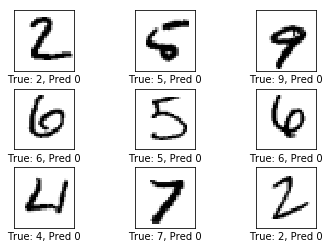

In [72]:
print_test_accuracy(show_example_error=True)

In [73]:
optimize(num_iterations=1000)

Optimization Iteration:    101, Training Accuracy:  71.9%
Optimization Iteration:    201, Training Accuracy:  82.8%
Optimization Iteration:    301, Training Accuracy:  85.9%
Optimization Iteration:    401, Training Accuracy:  92.2%
Optimization Iteration:    501, Training Accuracy:  92.2%
Optimization Iteration:    601, Training Accuracy:  92.2%
Optimization Iteration:    701, Training Accuracy:  89.1%
Optimization Iteration:    801, Training Accuracy:  90.6%
Optimization Iteration:    901, Training Accuracy:  87.5%
Optimization Iteration:   1001, Training Accuracy:  93.8%
Time to perform 1000 iterations: 0:01:49


Accuracy on Test-Set: 93.8% (9378 / 10000)
Example errors:


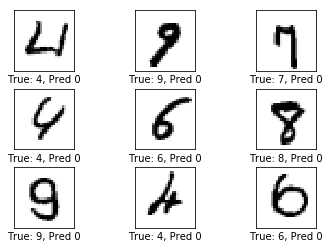

In [74]:
print_test_accuracy(show_example_error=True)

In [75]:
optimize(num_iterations=10000)

Optimization Iteration:   1101, Training Accuracy:  89.1%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  96.9%
Optimization Iteration:   1501, Training Accuracy:  95.3%
Optimization Iteration:   1601, Training Accuracy:  92.2%
Optimization Iteration:   1701, Training Accuracy:  98.4%
Optimization Iteration:   1801, Training Accuracy:  95.3%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy: 100.0%
Optimization Iteration:   2201, Training Accuracy:  82.8%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  96.9%
Optimization Iteration:   2501, Training Accuracy:  93.8%
Optimization Iteration:   2601, Training Accuracy:  93.8%
Optimization Iteration:   2701, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 98.9% (9887 / 10000)
Example errors:


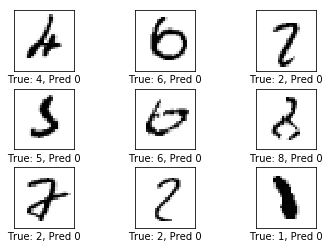

Confusion Matrix:
[[ 971    0    1    0    0    1    2    1    3    1]
 [   0 1129    2    0    0    0    1    1    2    0]
 [   2    1 1021    0    0    0    0    3    5    0]
 [   0    0    0 1005    0    2    0    1    2    0]
 [   0    0    1    0  974    0    0    0    1    6]
 [   2    0    0    4    0  883    1    0    0    2]
 [   5    2    0    0    2    5  943    0    1    0]
 [   0    2    6    2    1    0    0 1014    1    2]
 [   3    0    3    2    2    2    0    3  953    6]
 [   2    3    0    1    3    3    0    3    0  994]]


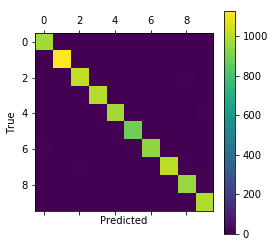

In [80]:
print_test_accuracy(show_example_error=True,
                    show_confusion_matrix=True)

## Visualizing Weights and Layers

In [101]:
def plot_conv_weights(weights, input_channel=0):
    w = sess.run(weights)
    w_min = np.min(weights)
    w_max = np.max(weights)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()